In [1]:
# import the necessary packages
import time
import cv2
import os
import time
from classify import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

In [2]:
tmpdir = unzip_archive("../net/2conv_20_32_2fc_128.tar.gz")
caffemodel = None
deploy_file = None
mean_file = None
labels_file = None
for filename in os.listdir(tmpdir):
    full_path = os.path.join(tmpdir, filename)
    if filename.endswith('.caffemodel'):
        caffemodel = full_path
    elif filename == 'deploy.prototxt':
            deploy_file = full_path
    elif filename.endswith('.binaryproto'):
            mean_file = full_path
    elif filename == 'labels.txt':
            labels_file = full_path
    else:
            print 'Unknown file:', filename

assert caffemodel is not None, 'Caffe model file not found'
assert deploy_file is not None, 'Deploy file not found'

###    # Load the model and images
net = get_net(caffemodel, deploy_file, use_gpu=False)
transformer = get_transformer(deploy_file, mean_file)
_, channels, height, width = transformer.inputs['data']
labels = read_labels(labels_file)

###    #create index from label to use in decicion action
number_label =  dict(zip(labels, range(len(labels))))
print number_label

###    #buffer_t = np.zeros((10) , dtype=np.int)
memory_temp_size = 10
num_itens = len(labels)
bucket = [0 for i in range(memory_temp_size)]
mem_p = {}
for i in labels:
    mem_p[i] = bucket

Unknown file: train_val.prototxt
Unknown file: info.json
Unknown file: solver.prototxt
Unknown file: original.prototxt
{'noBall': 1, 'Ball': 0}


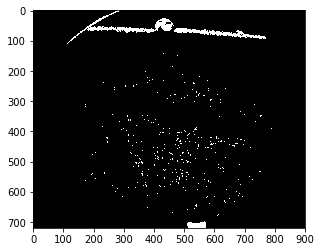

In [3]:
# load the image
image = cv2.imread("./images/longe_linha.png")
# image = cv2.imread("./images/longe.png")
# image = cv2.imread("./images/medio.png")
# image = cv2.imread("./images/perto.png")

YUV = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

mask_thr = cv2.inRange(YUV[:,:,0], 180, 255)
plt.imshow(cv2.cvtColor(mask_thr, cv2.COLOR_GRAY2RGB))

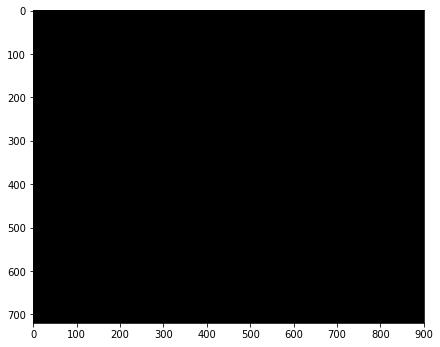

In [4]:
found_the_ball = False

kernel = np.ones((39, 39), np.uint8)
kernel2 = np.ones((100, 100), np.uint8)
mask = cv2.morphologyEx(mask_thr, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel2,1)
#Crops the top of the image, focusing only on objects near
mask[0:200,:] = 0

plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))

In [5]:
img=image.copy()
windows = []

gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,th1 = cv2.threshold(mask,25,255,cv2.THRESH_BINARY)
try:
    _,contours,hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
except:
    contours,hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img[y:y+h,x:x+w], cv2.COLOR_BGR2RGB))
    windows.append([img[y:y+h,x:x+w], x, y, w, h])

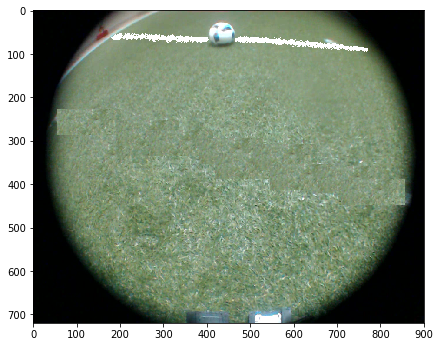

In [6]:
image_m = image.copy()
for images in windows:
    #Performed prediction for images----------------------------------------
    type_label, results = classify(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB),
                                               net, transformer,
                                               mean_file=mean_file, labels=labels,
                                               batch_size=None)
    #-----------------------------------------------------------------------
    print results, type_label

    if type_label == 'Ball':
        x, y, w, h = images[1], images[2], images[3], images[4]
        cv2.circle(image_m, (x+w/2, y+h/2), (w+h)/4, (0, 255, 0), 4)
        cv2.rectangle(image_m,(x,y),(x+w,y+h),(255,0,0),2)
        found_the_ball = True
        break
    ##        # Display the resulting frame
    #===============================================================================
    
plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(image_m, cv2.COLOR_BGR2RGB))

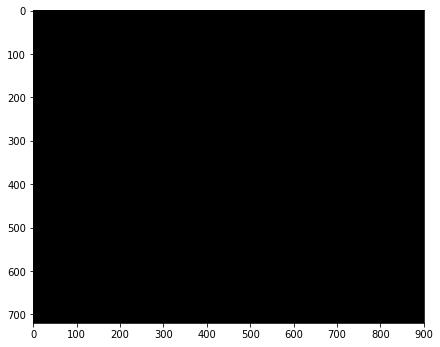

In [7]:
if found_the_ball == False:
    kernel = np.ones((22, 22), np.uint8)
    kernel2 = np.ones((80, 80), np.uint8)
    mask = cv2.morphologyEx(mask_thr, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel2,1)
    #Crops the bottom of the image, focusing only on the image center
    mask[600:,:] = 0

    plt.figure(figsize=(7,7))
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))

In [8]:
if found_the_ball == False:
    img=image.copy()
    windows = []

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,th1 = cv2.threshold(mask,25,255,cv2.THRESH_BINARY)
    try:
        _,contours,hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    except:
        contours,hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        plt.figure(figsize=(4,4))
        plt.imshow(cv2.cvtColor(img[y:y+h,x:x+w], cv2.COLOR_BGR2RGB))
        windows.append([img[y:y+h,x:x+w], x, y, w, h])

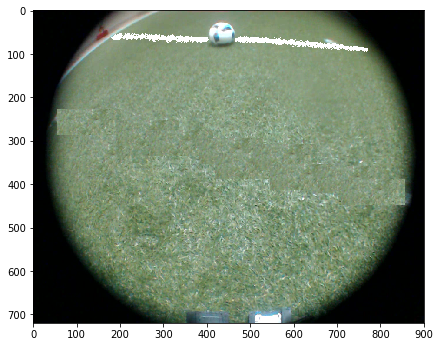

In [9]:
if found_the_ball == False:
    image_m = image.copy()
    for images in windows:
        #Performed prediction for images----------------------------------------
        type_label, results = classify(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB),
                                                   net, transformer,
                                                   mean_file=mean_file, labels=labels,
                                                   batch_size=None)
        #-----------------------------------------------------------------------
        print results, type_label

        if type_label == 'Ball':
            x, y, w, h = images[1], images[2], images[3], images[4]
            cv2.circle(image_m, (x+w/2, y+h/2), (w+h)/4, (0, 255, 0), 4)
            cv2.rectangle(image_m,(x,y),(x+w,y+h),(255,0,0),2)
            found_the_ball = True
            break
        ##        # Display the resulting frame
        #===============================================================================

    plt.figure(figsize=(7,7))
    plt.imshow(cv2.cvtColor(image_m, cv2.COLOR_BGR2RGB))

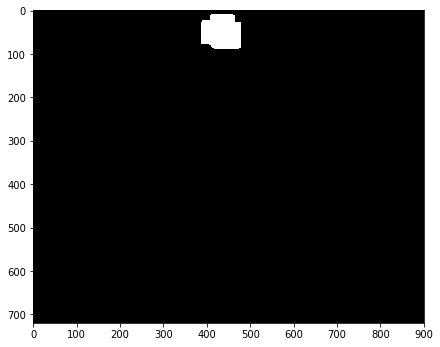

In [10]:
if found_the_ball == False:
    kernel = np.ones((12, 12), np.uint8)
    kernel2 = np.ones((40, 40), np.uint8)
    mask = cv2.morphologyEx(mask_thr, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel2,1)
    #Crops the bottom of the image, focusing only on far objects
    mask[500:,:] = 0
    
    plt.figure(figsize=(7,7))
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))

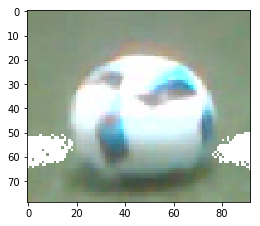

In [11]:
if found_the_ball == False:
    img=image.copy()
    windows = []

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,th1 = cv2.threshold(mask,25,255,cv2.THRESH_BINARY)
    try:
        _,contours,hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    except:
        contours,hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        plt.figure(figsize=(4,4))
        plt.imshow(cv2.cvtColor(img[y:y+h,x:x+w], cv2.COLOR_BGR2RGB))
        windows.append([img[y:y+h,x:x+w], x, y, w, h])

Processed 1/1 images in 0.023141 seconds ...
----------------------------- Prediction for image -----------------------------
100.0000% - "Ball"
  0.0000% - "noBall"

{'noBall': 0.0, 'Ball': 1.0} Ball


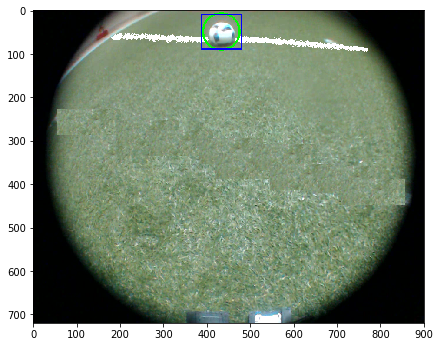

In [12]:
if found_the_ball == False:
    image_m = image.copy()
    for images in windows:
        #Performed prediction for images----------------------------------------
        type_label, results = classify(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB),
                                                   net, transformer,
                                                   mean_file=mean_file, labels=labels,
                                                   batch_size=None)
        #-----------------------------------------------------------------------
        print results, type_label

        if type_label == 'Ball':
            x, y, w, h = images[1], images[2], images[3], images[4]
            cv2.circle(image_m, (x+w/2, y+h/2), (w+h)/4, (0, 255, 0), 4)
            cv2.rectangle(image_m,(x,y),(x+w,y+h),(255,0,0),2)
            break
        ##        # Display the resulting frame
        #===============================================================================

    plt.figure(figsize=(7,7))
    plt.imshow(cv2.cvtColor(image_m, cv2.COLOR_BGR2RGB))

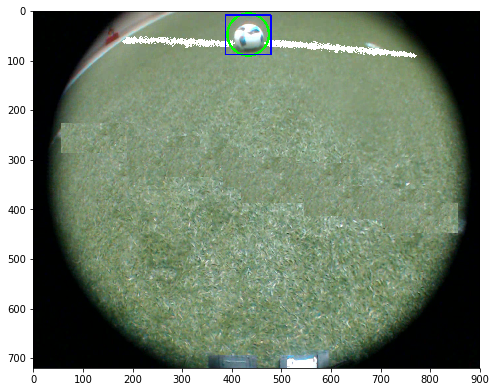

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(image_m, cv2.COLOR_BGR2RGB))